## Install module

In [ ]:
!pip install 'numpy<1.22'
!pip install pymc3
!pip3 install pyro-ppl

## PyMC3

In [ ]:
import torch
from torch.distributions import constraints
import pyro
import pymc3 as pm
import scipy.stats as stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

### model setting

In [ ]:
#observed
y_obs = [1,0,0,1,0,0,1]
#define model
with pm.Model() as model:
  #prior distribution
  theta = pm.Uniform('theta',lower=0,upper=1)
  #likelihood
  y = pm.Bernoulli('y',p=theta,shape=len(y_obs),observed=y_obs)
print(model.basic_RVs)

[theta_interval__ ~ TransformedDistribution, y ~ Bernoulli]


### inference setting (MCMC)

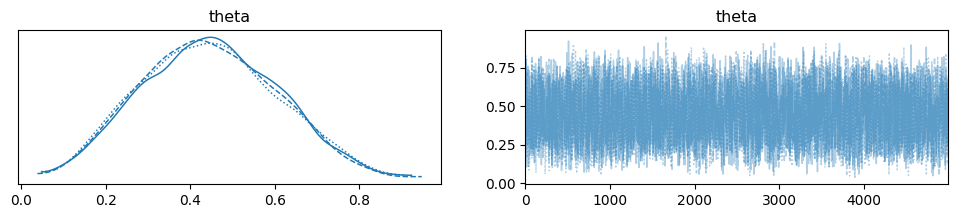

In [ ]:
with model:
  #inference by MCMC
  trace = pm.sample(
      draws = 5000, #sample size
      tune = 2000, #burn-in duration
      step=pm.NUTS(), #MCMC algorithm
      chains = 3, #num of chains
      random_seed = 1,
      return_inferencedata=True,#Rreturn InferenceData with ArviZ type
  )

  #plot trace plot
  az.plot_trace(trace)
  az.summary(trace)

### example modeling :: coin toss (prior : Beta, likelihood : bernoulli)


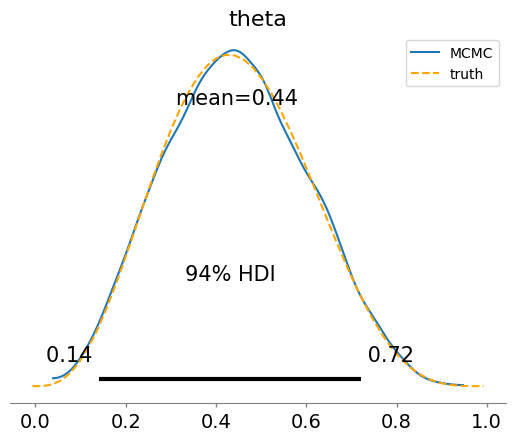

In [ ]:
N,n  = len(y_obs),np.sum(y_obs)
true_posterior = stats.beta(1+n,1+N-n) #analytical distribution
ax = az.plot_posterior(trace)
ax.lines[0].set_label("MCMC")

xx = np.linspace(*ax.get_xlim())
ax.plot(xx,true_posterior.pdf(xx),ls='--',color='orange',label='truth')
ax.legend()

## Pyro

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

Text(0, 0.5, 'Loss')

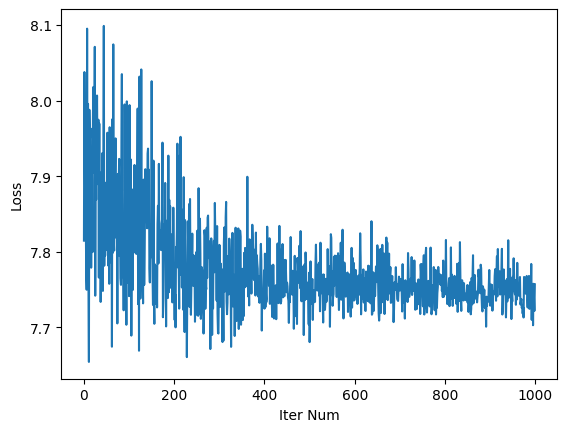

In [ ]:
#ovserve
y = torch.tensor([1,1,1,0,0,1,1,1,0,0],dtype=torch.float)

#define model
#batch_shape : num of probabilistic distributions
#event_shape : dim of probabilistic variables
def model(y):
  #prior distribution
  alpha = torch.tensor(1.0)
  beta = torch.tensor(1.0)
  theta = pyro.sample("theta",pyro.distributions.Beta(alpha,beta))
  #make independent samplles of observation
  with pyro.plate("sample",len(y)):
    #likelihood
    pyro.sample("obs",pyro.distributions.Bernoulli(theta),obs=y)

#inference by variational inference
#approximate distribution
def guide(y):
  #variational params to be optimized
  alpha_q = pyro.param("alpha_q",torch.tensor(5.0),constraint=constraints.positive)
  beta_q = pyro.param("beta_q",torch.tensor(5.0),constraint=constraints.positive)
  #assume beta distribution as approximate distribution
  pred_p = pyro.sample("theta",pyro.distributions.Beta(alpha_q,beta_q))
  return pred_p

#inference
#init params
pyro.clear_param_store()
#set optimizer
optimizer = pyro.optim.Adam({'lr':0.0005})
#SVI : set num of samples for calculating ELBO as 30
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO(num_particles=30))

#optimization process
loss_list = []
for step in range(1000):
  loss = svi.step(y)
  loss_list.append(loss)

plt.plot(loss_list)
plt.xlabel('Iter Num')
plt.ylabel('Loss')

### plot result

alpha_q
beta_q
variational posterior mean :nan
variational posterior std : nan
true posterior mean :nan
true posterior std : nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:628: RuntimeWarning: invalid value encountered in _beta_mean
  _boost._beta_mean(a, b),
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:629: RuntimeWarning: invalid value encountered in _beta_variance
  _boost._beta_variance(a, b),
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:630: RuntimeWarning: invalid value encountered in _beta_skewness
  _boost._beta_skewness(a, b),
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:631: RuntimeWarning: invalid value encountered in _beta_kurtosis_excess
  _boost._beta_kurtosis_excess(a, b))


Text(0.5, 0, '$theta$')

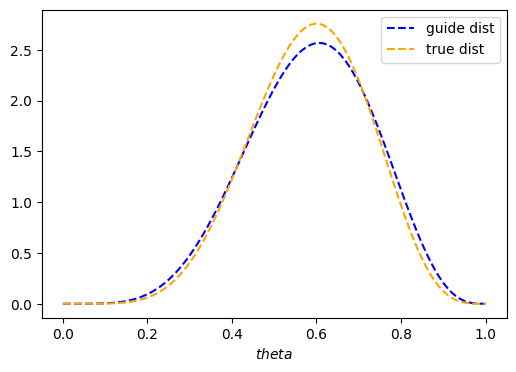

In [ ]:
#check global params
for para_name in pyro.get_param_store():
  print(para_name)

#features of distribution
alpha_q = pyro.param("alpha_q").detach().numpy() #numpy to tensor : .from_numpy(), tensor to numpy : x.detach().numpy()
beta_q = pyro.param("beta_q").detach().numpy()
variational_posterior = stats.beta(alpha_q,beta_q)
print("variational posterior mean :{:.3f}".format(variational_posterior.mean()))
print("variational posterior std : {:.3f}".format(variational_posterior.std()))

#true distribution
alpha_t = 1+torch.sum(y)
beta_t = 1+10-torch.sum(y)
true_posterior = stats.beta(alpha_t,beta_t)
print("true posterior mean :{:.3f}".format(true_posterior.mean()))
print("true posterior std : {:.3f}".format(true_posterior.std()))

#plot
x_lin = np.linspace(0,1.0,100)
fig,ax = plt.subplots(figsize=(6,4))
#approximate distribution
ax.plot(x_lin,variational_posterior.pdf(x_lin),ls='--',color='blue',label='guide dist')
#true
ax.plot(x_lin,true_posterior.pdf(x_lin),ls='--',color='orange',label='true dist')
ax.legend()
ax.set_xlabel('$theta$')

## NumPyro
- nearly equal to Pyro

In [ ]:
!pip install jax
!pip install numpyro

In [ ]:
import jax
import jax.numpy as jnp
import numpyro

In [ ]:
y = np.array([1,1,1,0,0,1,1,1,0,0],dtype=float)

#model setting
def model(y):
  alpha = jnp.array(1.0)
  beta = jnp.array(1.0)

  #priro distribution
  theta = numpyro.sample("theta",numpyro.distributions.Beta(alpha,beta))
  #make samples
  with numpyro.plate("sample",len(y)):
    numpyro.sample("obs",numpyro.distributions.Bernoulli(theta),obs=y)

#inference by NUTS(No U-turn sampler)
kernel = numpyro.infer.NUTS(model)
#setting of MCMC
mcmc = numpyro.infer.MCMC(kernel,num_warmup=500,num_samples=2000,num_chains=3)

#execution
mcmc.run(jax.random.PRNGKey(seed=1),y=y)

#plot result
#az.plot_trace(mcmc)
f#or var_info in az.rhat(mcmc).values():
 # print(var_info.nae,var_info.values.round(3),sep=' ')


<ipython-input-24-ab499062ab6f>:17: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel,num_warmup=500,num_samples=2000,num_chains=3)
sample: 100%|██████████| 2500/2500 [00:01<00:00, 1724.02it/s, 3 steps of size 8.32e-01. acc. prob=0.93]


ContextualVersionConflict: (numpy 1.21.6 (/usr/local/lib/python3.10/dist-packages), Requirement.parse('numpy>=1.22'), {'jax', 'jaxlib'})

### plot result

mcmc:samples mean : 0.584
mcmc:samples std: 0.138
true posterior mean : 0.583
true posterior std: 0.137


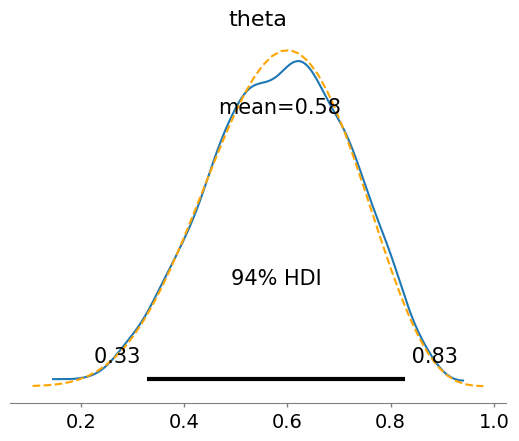

In [ ]:
#visualize sample from MCMC
samples = mcmc.get_samples()
ax = az.plot_posterior(samples)
x_lin = np.linspace(*ax.get_xlim())

#true distribution
true_posterior = stats.beta(1+np.sum(y),1+10-np.sum(y))
#visualize true distribution
ax.plot(x_lin,true_posterior.pdf(x_lin),ls="--",color="orange")

print("mcmc:samples mean : {:.3f}".format(samples["theta"].mean()))
print("mcmc:samples std: {:.3f}".format(samples["theta"].std()))
print("true posterior mean : {:.3f}".format(true_posterior.mean()))
print("true posterior std: {:.3f}".format(true_posterior.std()))